# Step 1: Cargando los datos y las librerías

"Sobre Cocinar Pizzas"

Success is a lousy teacher. It seduces smart people into thinking they can't lose.
 --- Bill Gates

In [ ]:
# Limpiamos el entorno
rm(list = ls())
gc(verbose = FALSE)

In [24]:
install.packages("rgenoud")

Installing package into 'C:/Users/German/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'rgenoud' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\German\AppData\Local\Temp\RtmpYzRNPU\downloaded_packages


In [25]:
# Librerías necesarias
require("data.table")
require("rpart")
require("ggplot2")
require("ROCR")
require("lubridate")
require("lhs")
require("DiceKriging")
require("mlrMBO")
require("rgenoud")

Loading required package: rgenoud



##  rgenoud (Version 5.9-0.3, Build Date: 2022-04-19)
##  See http://sekhon.berkeley.edu/rgenoud for additional documentation.
##  Please cite software as:
##   Walter Mebane, Jr. and Jasjeet S. Sekhon. 2011.
##   ``Genetic Optimization Using Derivatives: The rgenoud package for R.''
##   Journal of Statistical Software, 42(11): 1-26. 
##




In [3]:
# Aqui se debe poner la carpeta de la materia de SU computadora local
setwd("C:/Users/German/Desktop/dmeyf2023/German/Clase 1") # Establezco el Working Directory

# Poner sus semillas
semillas <- c(279511, 279523, 279541, 279551, 279571)

In [5]:
# Cargamos el dataset
dataset <- fread("competencia_01.csv")

# Nos quedamos solo con el 202103
dataset <- dataset[foto_mes == 202103]

In [6]:
# Creamos una clase binaria
dataset[, clase_binaria := ifelse(
                            clase_ternaria == "BAJA+2",
                                "evento",
                                "noevento"
                            )]
# Borramos el target viejo
dataset[, clase_ternaria := NULL]

In [7]:
# Seteamos nuestra primera semilla
set.seed(semillas[1])

# Particionamos de forma estratificada
in_training <- caret::createDataPartition(dataset$clase_binaria,
                     p = 0.70, list = FALSE)
dtrain  <-  dataset[in_training, ]
dtest   <-  dataset[-in_training, ]

# Step 2: Nuestra pizza: Un modelo

In [8]:
# Calculamos cuanto tarda un modelo "promedio" entrenar.
start_time <- Sys.time()
modelo <- rpart(clase_binaria ~ .,
                data = dtrain,
                xval = 0,
                cp = 0,
                minsplit = 20,
                minbucket = 10,
                maxdepth = 10)
pred_testing <- predict(modelo, dtest, type = "prob")
end_time <- Sys.time()
model_time <- end_time - start_time
print("Tiempo de ajuste en train y predict en test")
print(model_time)

ganancia <- function(probabilidades, clase) {
  return(sum(
    (probabilidades >= 0.025) * ifelse(clase == "evento", 273000, -7000))
  )
}

print("La ganancia NORMALIZADA de nuestro modelo es:")
print(ganancia(pred_testing[, "evento"], dtest$clase_binaria) / 0.3)

[1] "Tiempo de ajuste en train y predict en test"
Time difference of 7.745408 secs
[1] "La ganancia NORMALIZADA de nuestro modelo es:"
[1] 71726667


**Preguntas**
- ¿Es acaso este el mejor modelo posible?
- ¿Dónde lo buscamos el mejor modelo?
- ¿Qué parámetros conoce para un árbol de decisión?
- ¿Qué espacios de búsqueda tienen los parámetros *maxdepth* y *minsplit*?
- ¿Cómo se imagina la interacción entre esto dos últimos parámetros?

# Step 3: There Ain't No Such Thing As A Free Lunch

In [9]:
# Supongamos que sólo vamos a buscar sobre los parámetros *maxdepth* y
# *minsplit*

# Tamaño del espacio de búsqueda de *maxdepth*
n_md <- 30 - 4
# Tamaño del espacio de búsqueda de *minsplit*
n_ms <- 200 - 2
# Cantidad de semillas
n_seeds <- 5

# Estimación de cuanto tardaría en buscar el mejor modelo con 2 parámetros.
print(seconds_to_period(n_md * n_ms * n_seeds * model_time))

# Tamaño del espacio de búsqueda de *minbucket*
n_mb <- 100 - 2

# Estimación de cuanto tardaría en buscar el mejor modelo con 3 parámetros.
print(seconds_to_period(n_md * n_ms * n_seeds * model_time * n_mb))

[1] "2d 7H 22M 46.8034172058105S"
[1] "226d 3H 12M 26.7348861694336S"


**Preguntas**
- ¿Dispone del tiempo para realizar esta búsqueda?
- ¿Qué hacemos cuándo un parámetro tiene valores continuos?

# Step 4: Empezando a probar con menos casos

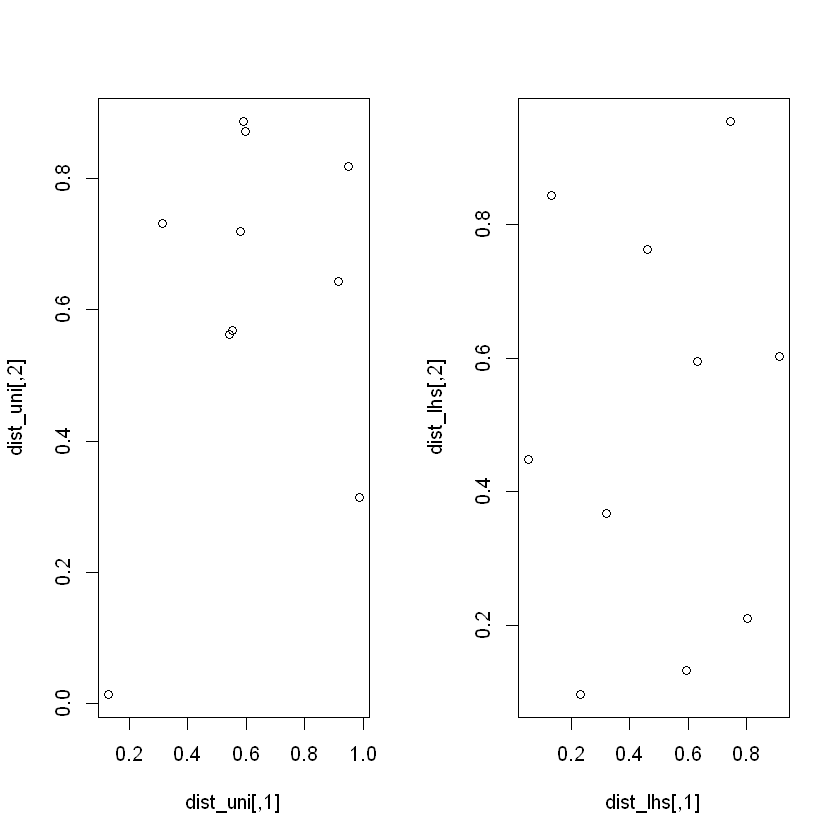

In [10]:
set.seed(semillas[1])
dist_uni <- matrix(runif(20), 10, 2)

# LHS Latin hypercube sampling
set.seed(semillas[1])
dist_lhs <- optimumLHS(10, 2)

par(mfrow = c(1, 2))
plot(dist_uni)
plot(dist_lhs)

**Preguntas**
- ¿Cuál distribución considera mejor? Justifique

# Step 5: "Tomando una muestra de sangre"

In [11]:
# Armamos una función para modelar con el fin de simplificar el código futuro
modelo_rpart <- function(train, test, cp =  0, ms = 20, mb = 1, md = 10) {
    modelo <- rpart(clase_binaria ~ ., data = train,
                    xval = 0,
                    cp = cp,
                    minsplit = ms,
                    minbucket = mb,
                    maxdepth = md)

    test_prediccion <- predict(modelo, test, type = "prob")
    roc_pred <-  ROCR::prediction(test_prediccion[, "evento"],
                    test$clase_binaria,
                                  label.ordering = c("noevento", "evento"))
    auc_t <-  ROCR::performance(roc_pred, "auc")

    unlist(auc_t@y.values)
}

In [12]:
# Función para tomar un muestra dejando todos los elementos de la clase BAJA+2
tomar_muestra <- function(datos, resto = 10000) {
      t <- datos$clase_binaria == "evento"
      r <- rep(FALSE, length(datos$clase_binaria))
      r[!t][sample.int(resto, n = (length(t) - sum(t)))] <- TRUE
      t | r
}

In [13]:
set.seed(semillas[1])
ds_sample <- tomar_muestra(dataset)
table(dataset[ds_sample]$clase_binaria)



  evento noevento 
    1049    10000 

**Preguntas**
- ¿Qué tipo de muestre se tomó?
- ¿Hay mejores formas de muestrear?
- ¿Es bueno muestrear?
- ¿Qué efectos en las métricas va a producir el muestreo?
- ¿Por qué se eligió usar el AUC?
- ¿Qué hay que cambiar en la función de ganancia para poder utilizarla?

# Step 6: Comparando tiempos con o sin muestras

In [14]:
t0 <- Sys.time()
r1 <- modelo_rpart(dtrain, dtest)
t1 <- Sys.time()
print("Train entero")
print(t1 - t0)
print(r1)

[1] "Train entero"
Time difference of 8.149401 secs
[1] 0.8767164


In [15]:
set.seed(semillas[1])
dtrain_sample <- tomar_muestra(dtrain)

In [16]:
t0 <- Sys.time()
r2 <- modelo_rpart(dtrain[dtrain_sample, ], dtest)
t1 <- Sys.time()
print("Muestra train")
print(t1 - t0)
print(r2)

[1] "Muestra train"
Time difference of 0.8057709 secs
[1] 0.8582668


Preguntas
- ¿Por qué sólo se muestrea train?

# Step 7: Buscando el mejor modelo con muestras aleatorias LHS

In [17]:
# Una función auxiliar para los experimentos
experimento_rpart <- function(ds, semillas, cp = 0, ms = 20, mb = 1, md = 10) {
  auc <- c()
  for (s in semillas) {
    set.seed(s)
    in_training <- caret::createDataPartition(ds$clase_binaria, p = 0.70,
        list = FALSE)
    train  <-  ds[in_training, ]
    test   <-  ds[-in_training, ]
    train_sample <- tomar_muestra(train)
    r <- modelo_rpart(train[train_sample,], test, 
                    cp = cp, ms = ms, mb = mb, md = md)
    auc <- c(auc, r)
  }
  mean(auc)
}

    md  ms       auc
 1: 12  54 0.8711736
 2: 18  79 0.8700500
 3:  6 150 0.8759515
 4: 16 188 0.8817030
 5:  5 183 0.8638452
 6: 13 139 0.8807381
 7:  9  20 0.8658259
 8: 18 132 0.8773719
 9:  8  36 0.8724344
10:  4  30 0.8488628
11: 12 112 0.8790455
12: 10 128 0.8805852
13:  6  11 0.8731927
14:  7  67 0.8774589
15:  9  95 0.8817945
16: 17  64 0.8683098
17: 11  89 0.8792865
18: 14  43 0.8578880
19: 15 154 0.8804674
20: 11 166 0.8818118
21: 14 117 0.8782123
22: 13 170 0.8802753
23: 16   8 0.7318961
24:  4 100 0.8492096
25:  7 194 0.8770694
    md  ms       auc


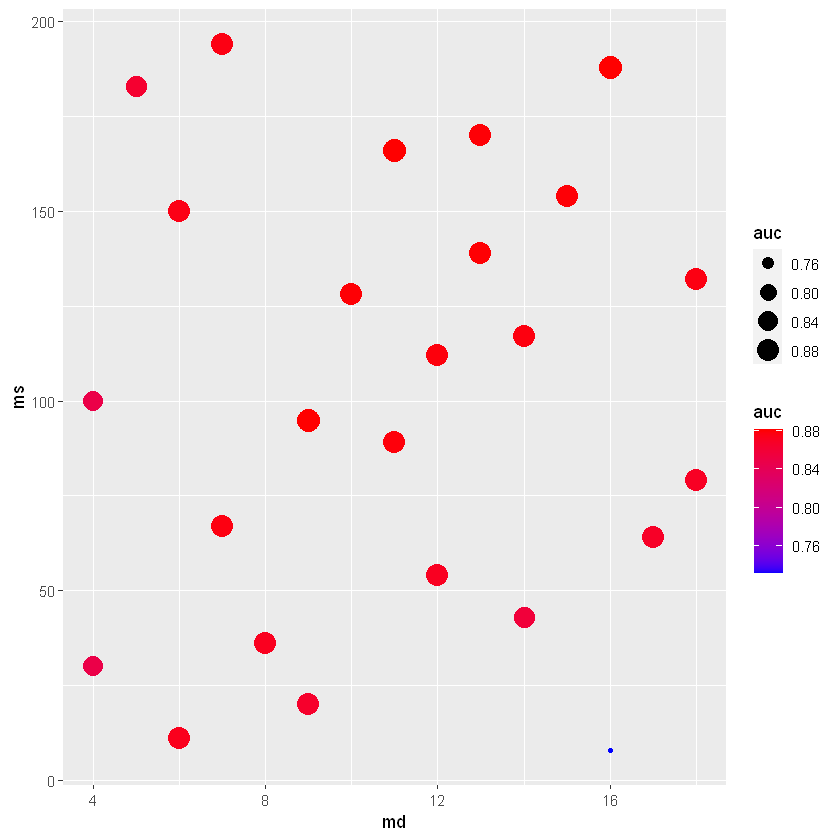

In [18]:
# Haremos 25 experimentos aleatorios, armamos las muestras de acuerdo a como
# son las entradas de nuestro experimento.

set.seed(semillas[1])
cantidad_puntos <- 25
espacio_busqueda_1 <- optimumLHS(cantidad_puntos, 2)

# la primera columna es para el maxdepth, y la segunda para el minslip
espacio_busqueda_1[, 1] <- floor(15 * espacio_busqueda_1[, 1]) + 4
espacio_busqueda_1[, 2] <- floor(200 * espacio_busqueda_1[, 2]) + 2

resultados_random_search <- data.table()
for (e in 1:cantidad_puntos) {
  r <- experimento_rpart(dataset, semillas,
                        ms = espacio_busqueda_1[e, 2],
                        md = espacio_busqueda_1[e, 1])
  resultados_random_search <- rbindlist(list(resultados_random_search,
                  data.table(
                    md = espacio_busqueda_1[e, 1],
                    ms = espacio_busqueda_1[e, 2],
                    auc = r)
  ))
}

print(resultados_random_search)
ggplot(resultados_random_search, aes(x = md, y = ms, color = auc)) +
    scale_color_gradient(low = "blue", high = "red") +
    geom_point(aes(size = auc))

Preguntas
- ¿Hay alguna zona dónde parece que hay más ganancia?
- ¿Cómo podemos continuar nuestra búsqueda?

# Step 8: Trabajando con herramientas más profesionales


In [26]:
# Veamos un ejemplo
set.seed(semillas[1])
obj_fun <- makeSingleObjectiveFunction(
  name = "Sine",
  fn = function(x) sin(x),
  par.set = makeNumericParamSet(lower = 3, upper = 13, len = 1)
)

ctrl <- makeMBOControl()
ctrl <- setMBOControlTermination(ctrl, iters = 10L)
ctrl <- setMBOControlInfill(ctrl, crit = makeMBOInfillCritEI(),
                           opt = "focussearch")

lrn <- makeMBOLearner(ctrl, obj_fun)
design <- generateDesign(6L, getParamSet(obj_fun), fun = lhs::maximinLHS)

run <- exampleRun(obj_fun, design = design, learner = lrn,
                 control = ctrl, points.per.dim = 100, show.info = TRUE)

Evaluating true objective function at 100 points.

Performing MBO on function.

Learner: regr.km. Settings:
jitter=FALSE,covtype=matern3_2,optim.method=gen,nugget.stability=1e-08

Computing y column(s) for design. Not provided.

[mbo] 0: x=6.86 : y = 0.542 : 0.0 secs : initdesign

[mbo] 0: x=5.6 : y = -0.629 : 0.0 secs : initdesign

[mbo] 0: x=12.8 : y = 0.217 : 0.0 secs : initdesign

[mbo] 0: x=10.9 : y = -0.994 : 0.0 secs : initdesign

[mbo] 0: x=3.35 : y = -0.203 : 0.0 secs : initdesign

[mbo] 0: x=8.22 : y = 0.935 : 0.0 secs : initdesign




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 5.272435e-09 
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  18.8782 
  - variance bounds :  0.02547322 5.272435 
  - best initial criterion value(s) :  -6.271795 


Wed Aug 30 00:04:36 2023
Domains:
 1.000000e-10   <=  X1   <=    1.887820e+01 
 2.547322e-02   <=  X2   <=    5.272435e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	3
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	0
	(6) Simple Crossover.................. 	0
	(7) Whole Non-Uniform Mutation........ 	0
	(8) Heuristic Crossover............... 	0
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Gene

[mbo] 1: x=10.6 : y = -0.927 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 5.564978e-09 
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  18.8782 
  - variance bounds :  0.03269355 5.564978 
  - best initial criterion value(s) :  -6.278113 


Wed Aug 30 00:04:37 2023
Domains:
 1.000000e-10   <=  X1   <=    1.887820e+01 
 3.269355e-02   <=  X2   <=    5.564978e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	3
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	0
	(6) Simple Crossover.................. 	0
	(7) Whole Non-Uniform Mutation........ 	0
	(8) Heuristic Crossover............... 	0
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Gene

[mbo] 2: x=11.3 : y = -0.958 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 5.583179e-09 
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  18.8782 
  - variance bounds :  0.04151783 5.583179 
  - best initial criterion value(s) :  -5.996528 


Wed Aug 30 00:04:37 2023
Domains:
 1.000000e-10   <=  X1   <=    1.887820e+01 
 4.151783e-02   <=  X2   <=    5.583179e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	3
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	0
	(6) Simple Crossover.................. 	0
	(7) Whole Non-Uniform Mutation........ 	0
	(8) Heuristic Crossover............... 	0
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Gene

[mbo] 3: x=4.76 : y = -0.999 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 5.505036e-09 
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  18.8782 
  - variance bounds :  0.03641866 5.505035 
  - best initial criterion value(s) :  -12.67779 


Wed Aug 30 00:04:38 2023
Domains:
 1.000000e-10   <=  X1   <=    1.887820e+01 
 3.641866e-02   <=  X2   <=    5.505035e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	3
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	0
	(6) Simple Crossover.................. 	0
	(7) Whole Non-Uniform Mutation........ 	0
	(8) Heuristic Crossover............... 	0
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Gene

[mbo] 4: x=4.99 : y = -0.962 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 5.286114e-09 
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  18.8782 
  - variance bounds :  0.03296095 5.286114 
  - best initial criterion value(s) :  -10.09012 


Wed Aug 30 00:04:38 2023
Domains:
 1.000000e-10   <=  X1   <=    1.887820e+01 
 3.296095e-02   <=  X2   <=    5.286114e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	3
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	0
	(6) Simple Crossover.................. 	0
	(7) Whole Non-Uniform Mutation........ 	0
	(8) Heuristic Crossover............... 	0
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Gene

[mbo] 5: x=4.47 : y = -0.971 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 5.055668e-09 
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  18.8782 
  - variance bounds :  0.03619676 5.055668 
  - best initial criterion value(s) :  -4.037319 


Wed Aug 30 00:04:38 2023
Domains:
 1.000000e-10   <=  X1   <=    1.887820e+01 
 3.619676e-02   <=  X2   <=    5.055668e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	3
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	0
	(6) Simple Crossover.................. 	0
	(7) Whole Non-Uniform Mutation........ 	0
	(8) Heuristic Crossover............... 	0
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Gene

[mbo] 6: x=11.1 : y = -0.998 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 4.846441e-09 
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  18.8782 
  - variance bounds :  0.03437544 4.846441 
  - best initial criterion value(s) :  -48.92118 


Wed Aug 30 00:04:39 2023
Domains:
 1.000000e-10   <=  X1   <=    1.887820e+01 
 3.437544e-02   <=  X2   <=    4.846441e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	3
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	0
	(6) Simple Crossover.................. 	0
	(7) Whole Non-Uniform Mutation........ 	0
	(8) Heuristic Crossover............... 	0
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Gene

[mbo] 7: x=4.65 : y = -0.998 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 4.636586e-09 
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  18.8782 
  - variance bounds :  0.03577606 4.636586 
  - best initial criterion value(s) :  -0.3939174 


Wed Aug 30 00:04:39 2023
Domains:
 1.000000e-10   <=  X1   <=    1.887820e+01 
 3.577606e-02   <=  X2   <=    4.636586e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	3
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	0
	(6) Simple Crossover.................. 	0
	(7) Whole Non-Uniform Mutation........ 	0
	(8) Heuristic Crossover............... 	0
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Gen

[mbo] 8: x=11 : y = -1 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 4.43482e-09 
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  18.8782 
  - variance bounds :  0.03035779 4.43482 
  - best initial criterion value(s) :  5.694509 


Wed Aug 30 00:04:39 2023
Domains:
 1.000000e-10   <=  X1   <=    1.887820e+01 
 3.035779e-02   <=  X2   <=    4.434820e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	3
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	0
	(6) Simple Crossover.................. 	0
	(7) Whole Non-Uniform Mutation........ 	0
	(8) Heuristic Crossover............... 	0
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Generat

[mbo] 9: x=4.71 : y = -1 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 4.242749e-09 
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  18.8782 
  - variance bounds :  0.0312936 4.242749 
  - best initial criterion value(s) :  10.09968 


Wed Aug 30 00:04:39 2023
Domains:
 1.000000e-10   <=  X1   <=    1.887820e+01 
 3.129360e-02   <=  X2   <=    4.242749e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	3
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	0
	(6) Simple Crossover.................. 	0
	(7) Whole Non-Uniform Mutation........ 	0
	(8) Heuristic Crossover............... 	0
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Genera

[mbo] 10: x=11 : y = -1 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 4.061679e-09 
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  18.8782 
  - variance bounds :  0.02974745 4.061679 
  - best initial criterion value(s) :  15.21491 


Wed Aug 30 00:04:40 2023
Domains:
 1.000000e-10   <=  X1   <=    1.887820e+01 
 2.974745e-02   <=  X2   <=    4.061679e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	3
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	0
	(6) Simple Crossover.................. 	0
	(7) Whole Non-Uniform Mutation........ 	0
	(8) Heuristic Crossover............... 	0
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Gener

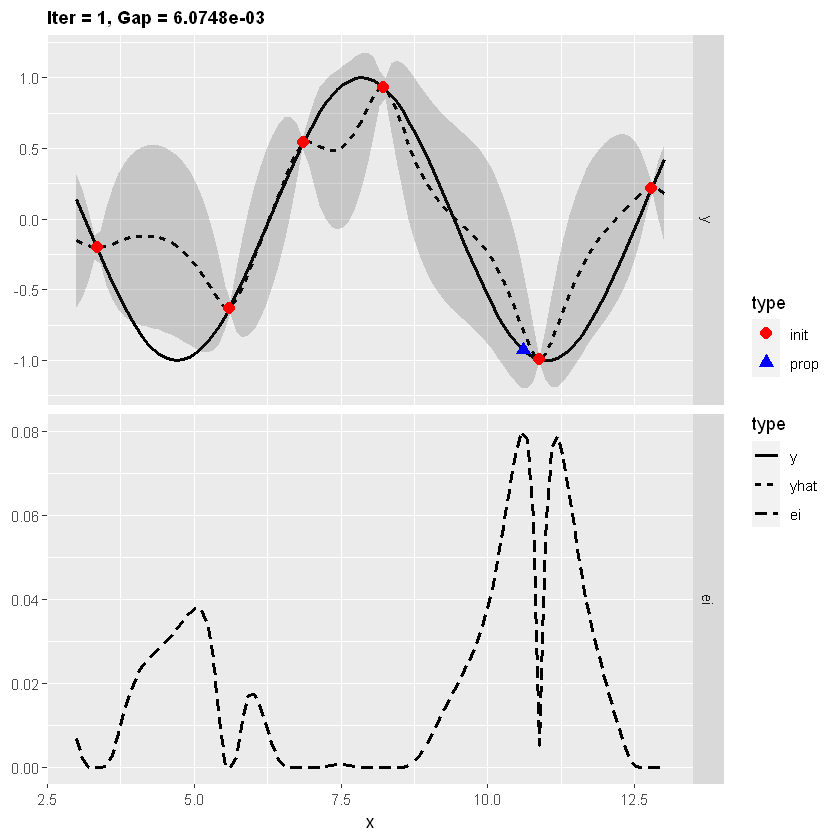

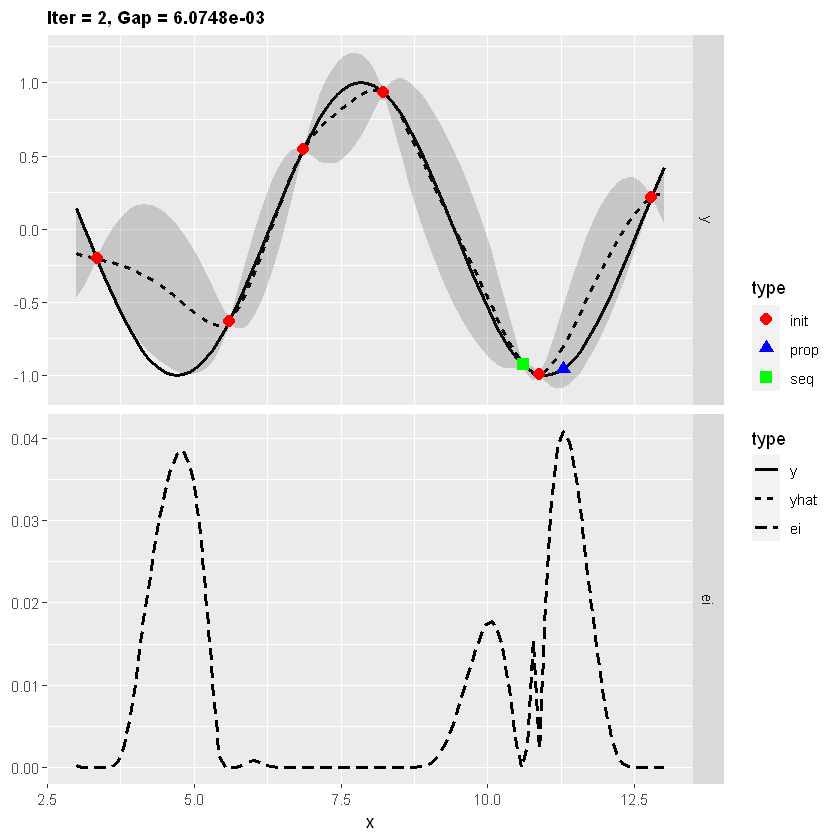

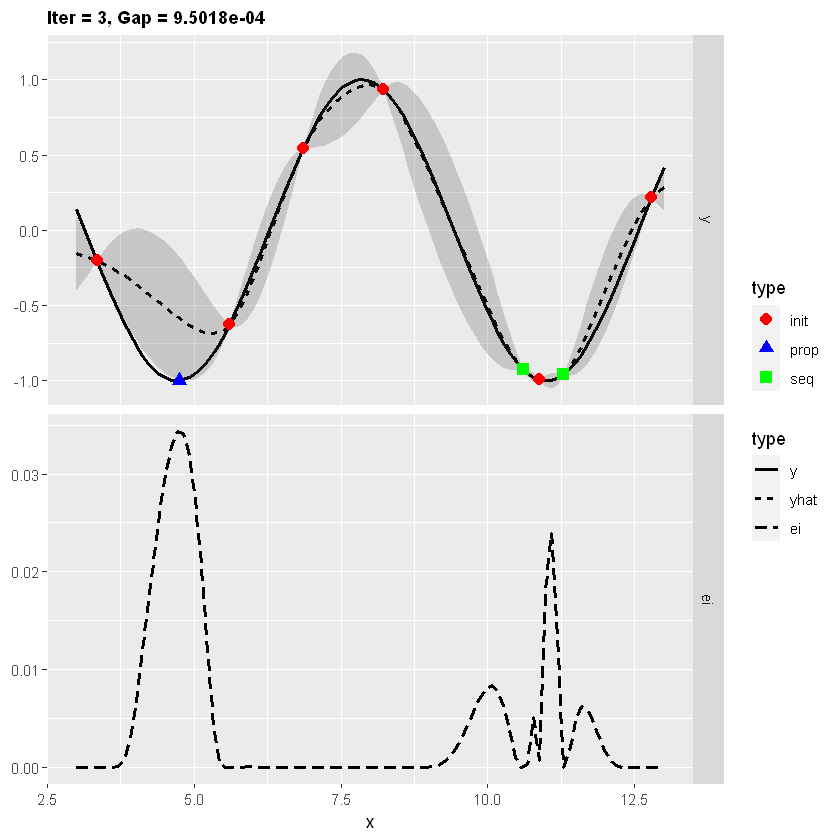

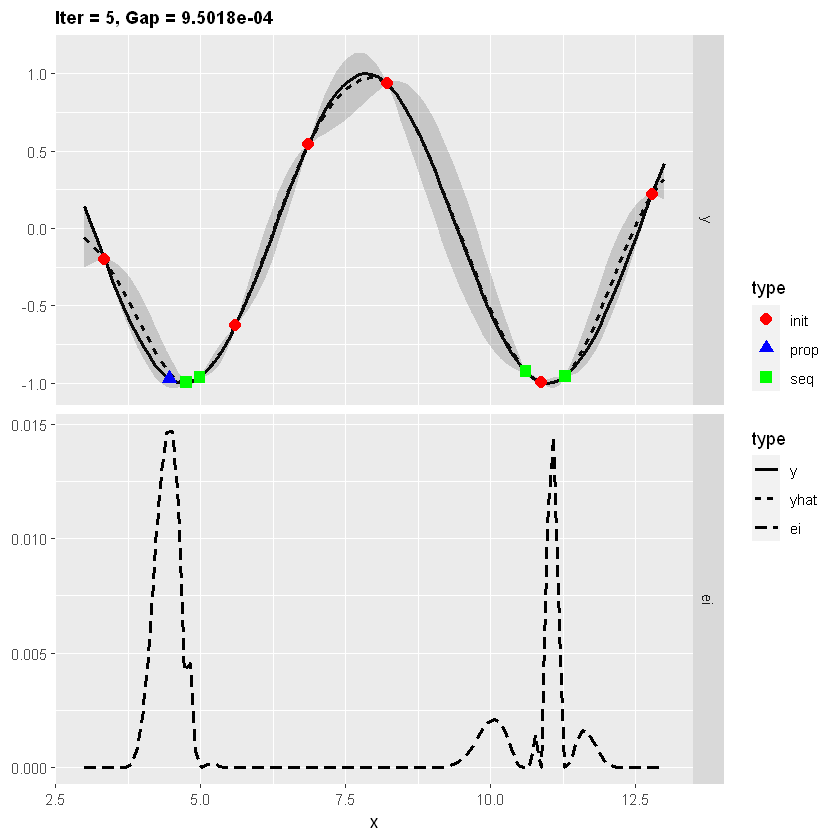

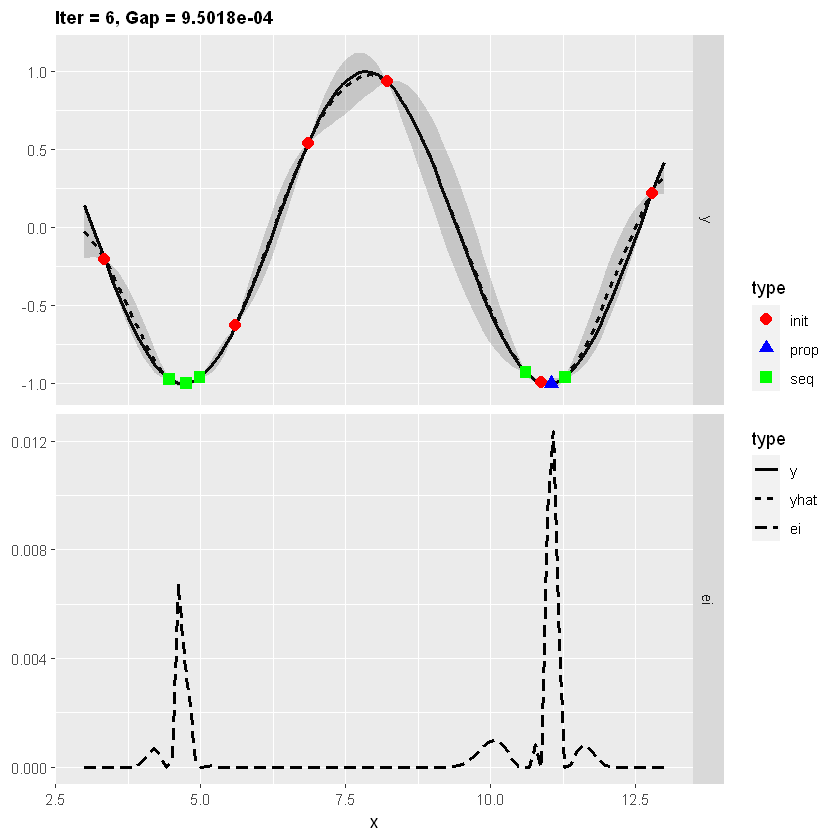

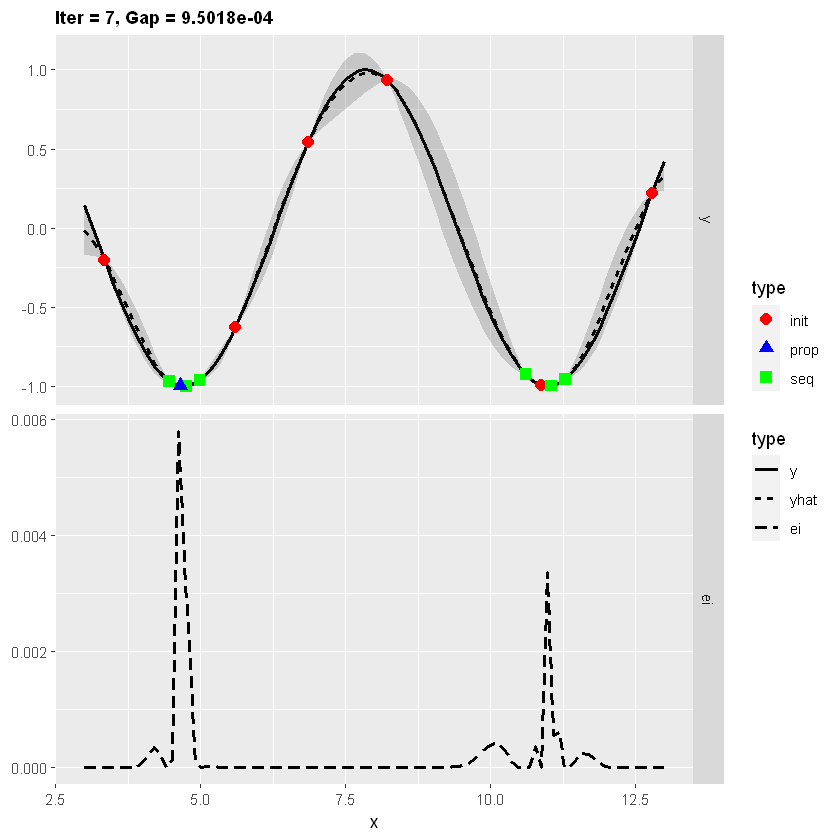

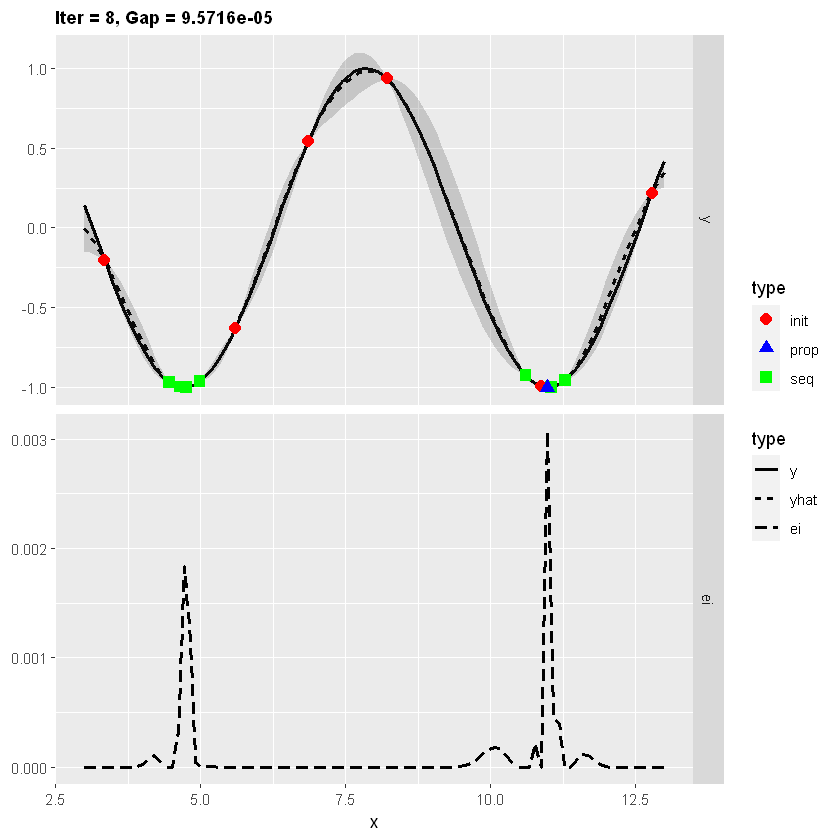

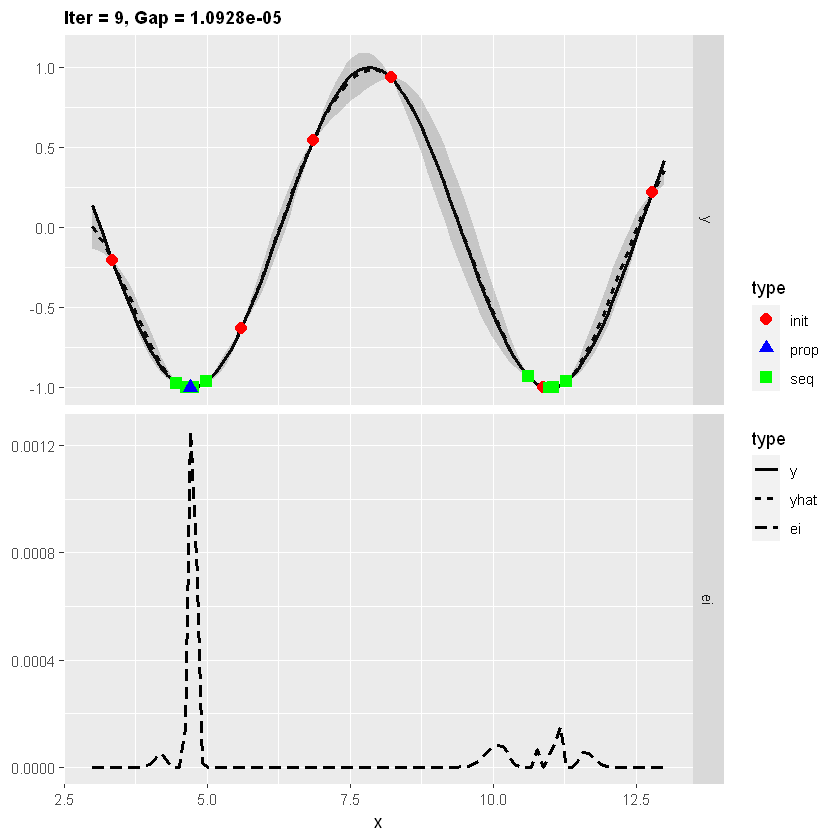

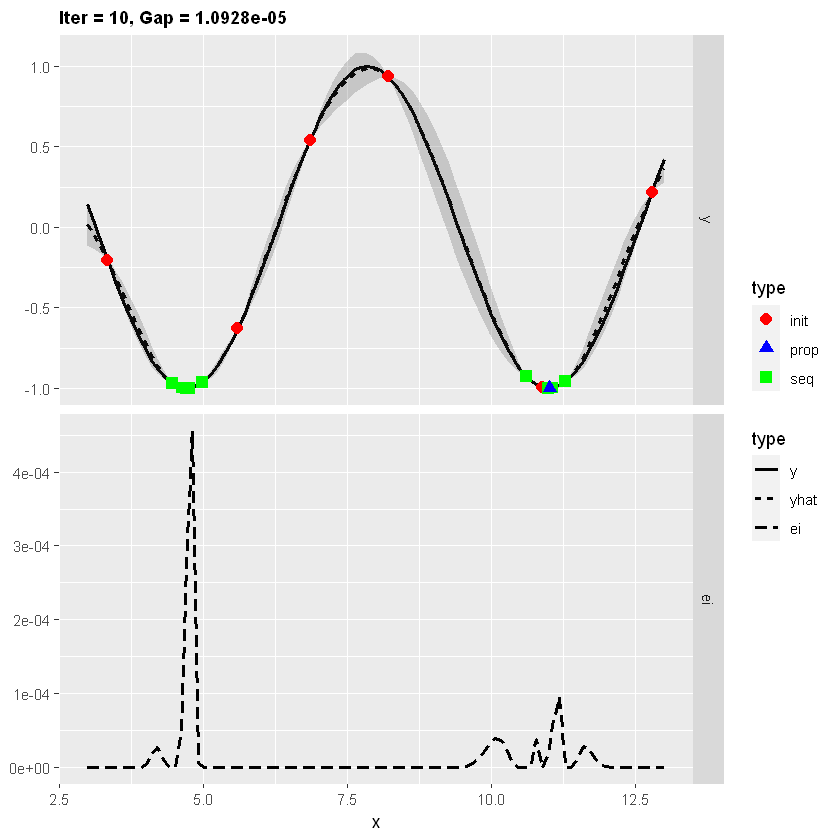

In [27]:
# Ejecutar de a uno
plotExampleRun(run, iters = 1, densregion = TRUE, pause = FALSE)
plotExampleRun(run, iters = 2, densregion = TRUE, pause = FALSE)
plotExampleRun(run, iters = 3, densregion = TRUE, pause = FALSE)
plotExampleRun(run, iters = 5, densregion = TRUE, pause = FALSE)
plotExampleRun(run, iters = 6, densregion = TRUE, pause = FALSE)
plotExampleRun(run, iters = 7, densregion = TRUE, pause = FALSE)
plotExampleRun(run, iters = 8, densregion = TRUE, pause = FALSE)
plotExampleRun(run, iters = 9, densregion = TRUE, pause = FALSE)
plotExampleRun(run, iters = 10, densregion = TRUE, pause = FALSE)

# Step 9: Introduciendo la técnica en nuestro conjunto

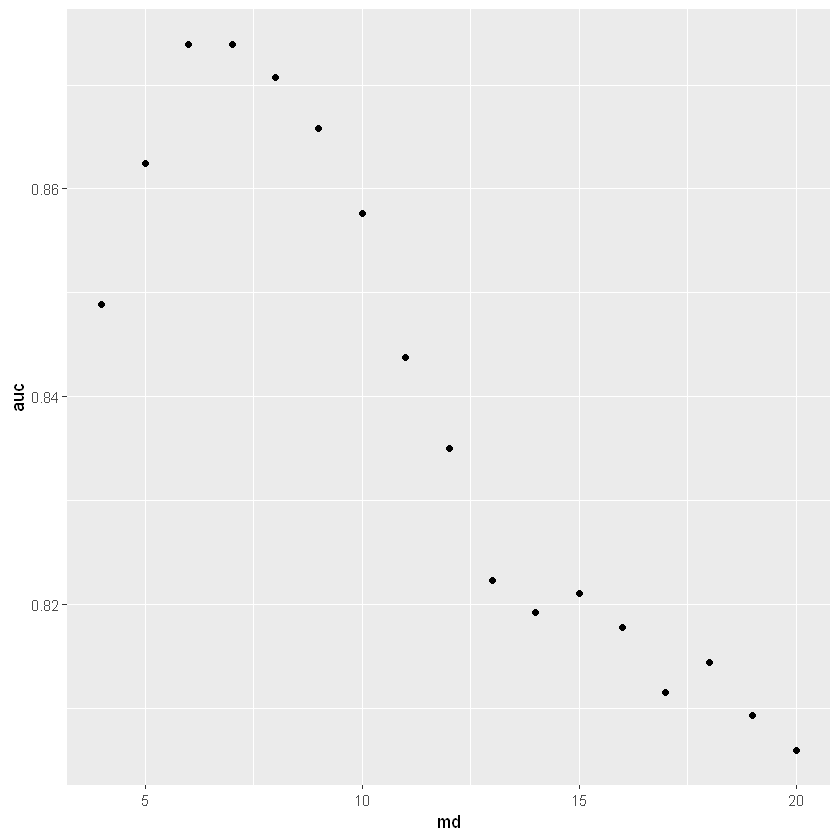

In [28]:
resultados_maxdepth <- data.table()

for (v in 4:20) {
    r <- data.table(
      md = v,
      auc = experimento_rpart(dataset, semillas, md = v)
    )
    resultados_maxdepth <- rbindlist(list(resultados_maxdepth, r))
}

ggplot(resultados_maxdepth, aes(md, auc)) + geom_point()

# Step 10: Buscando con una Opt. Bayesiana para 1 parámetro

In [29]:
set.seed(semillas[1])
obj_fun_md <- function(x) {
  experimento_rpart(dataset, semillas, md = x$maxdepth)
}

obj_fun <- makeSingleObjectiveFunction(
  minimize = FALSE,
  fn = obj_fun_md,
  par.set = makeParamSet(
    makeIntegerParam("maxdepth",  lower = 4L, upper = 20L)
  ),
  # noisy = TRUE,
  has.simple.signature = FALSE
)

ctrl <- makeMBOControl()
ctrl <- setMBOControlTermination(ctrl, iters = 10L)
ctrl <- setMBOControlInfill(
  ctrl,
  crit = makeMBOInfillCritEI(),
  opt = "focussearch",
  opt.focussearch.points = 2
)

In [30]:
lrn <- makeMBOLearner(ctrl, obj_fun)

surr_km <- makeLearner("regr.km", predict.type = "se", covtype = "matern3_2")

run_md <- mbo(obj_fun, learner = surr_km, control = ctrl)
print(run_md)

Computing y column(s) for design. Not provided.

[mbo] 0: maxdepth=10 : y = 0.858 : 5.6 secs : initdesign

[mbo] 0: maxdepth=19 : y = 0.809 : 6.6 secs : initdesign

[mbo] 0: maxdepth=5 : y = 0.862 : 3.7 secs : initdesign

[mbo] 0: maxdepth=14 : y = 0.819 : 5.7 secs : initdesign




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  28 
  - best initial criterion value(s) :  9.807585 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -9.8076  |proj g|=     0.034079
At iterate     1  f =      -9.8087  |proj g|=       0.03229
At iterate     2  f =       -9.818  |proj g|=     0.0029258
At iterate     3  f =      -9.8181  |proj g|=    0.00020319
At iterate     4  f =      -9.8181  |proj g|=    1.0603e-06
At iterate     5  f =      -9.8181  |proj g|=    3.9056e-10

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 3.90564e-10
final function value

[mbo] 1: maxdepth=7 : y = 0.874 : 4.6 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  28 
  - best initial criterion value(s) :  13.06621 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -13.066  |proj g|=     0.039612
At iterate     1  f =      -13.068  |proj g|=      0.036423
At iterate     2  f =      -13.075  |proj g|=     0.0043937
At iterate     3  f =      -13.075  |proj g|=    0.00040277
At iterate     4  f =      -13.075  |proj g|=    3.8565e-06
At iterate     5  f =      -13.075  |proj g|=    3.4398e-09

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 3.43977e-09
final function value

[mbo] 2: maxdepth=8 : y = 0.871 : 5.4 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  28 
  - best initial criterion value(s) :  17.72951 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -17.73  |proj g|=     0.024861
At iterate     1  f =       -17.73  |proj g|=       0.02267
At iterate     2  f =      -17.733  |proj g|=     0.0017598
At iterate     3  f =      -17.733  |proj g|=    0.00011115
At iterate     4  f =      -17.733  |proj g|=    4.9771e-07
At iterate     5  f =      -17.733  |proj g|=    1.4171e-10

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.4171e-10
final function value 

[mbo] 3: maxdepth=6 : y = 0.874 : 4.6 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  28 
  - best initial criterion value(s) :  21.3956 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -21.396  |proj g|=      0.12832
At iterate     1  f =      -21.411  |proj g|=       0.11606
At iterate     2  f =      -21.449  |proj g|=      0.082664
At iterate     3  f =      -21.463  |proj g|=      0.021318
At iterate     4  f =      -21.464  |proj g|=     0.0028622
At iterate     5  f =      -21.464  |proj g|=    0.00012318
At iterate     6  f =      -21.464  |proj g|=     6.687e-07

iterations 6
function evaluations 7
segments explored during Cauchy searches 6
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of th

[mbo] 4: maxdepth=4 : y = 0.849 : 3.9 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  30 
  - best initial criterion value(s) :  25.60539 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -25.605  |proj g|=      0.10298
At iterate     1  f =      -25.616  |proj g|=      0.094573
At iterate     2  f =      -25.648  |proj g|=      0.058719
At iterate     3  f =      -25.657  |proj g|=      0.015035
At iterate     4  f =      -25.658  |proj g|=     0.0017714
At iterate     5  f =      -25.658  |proj g|=    6.4007e-05
At iterate     6  f =      -25.658  |proj g|=    2.5912e-07

iterations 6
function evaluations 7
segments explored during Cauchy searches 6
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of t

[mbo] 5: maxdepth=9 : y = 0.866 : 5.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  30 
  - best initial criterion value(s) :  30.81775 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -30.818  |proj g|=     0.034501
At iterate     1  f =      -30.819  |proj g|=      0.030841
At iterate     2  f =      -30.823  |proj g|=     0.0036906
At iterate     3  f =      -30.823  |proj g|=    0.00033496
At iterate     4  f =      -30.823  |proj g|=    3.2283e-06
At iterate     5  f =      -30.823  |proj g|=     2.862e-09

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 2.86199e-09
final function value

[mbo] 6: maxdepth=11 : y = 0.844 : 7.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  30 
  - best initial criterion value(s) :  34.9384 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -34.938  |proj g|=     0.053519
At iterate     1  f =      -34.941  |proj g|=      0.047733
At iterate     2  f =       -34.95  |proj g|=     0.0096678
At iterate     3  f =       -34.95  |proj g|=     0.0013268
At iterate     4  f =      -34.951  |proj g|=    3.0967e-05
At iterate     5  f =      -34.951  |proj g|=    1.0247e-07

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.02474e-07
final function value 

[mbo] 7: maxdepth=17 : y = 0.812 : 8.5 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  30 
  - best initial criterion value(s) :  38.93257 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -38.933  |proj g|=     0.019268
At iterate     1  f =      -38.933  |proj g|=       0.01692
At iterate     2  f =      -38.934  |proj g|=    0.00097662
At iterate     3  f =      -38.934  |proj g|=    4.5753e-05
At iterate     4  f =      -38.934  |proj g|=    1.1622e-07

iterations 4
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.16225e-07
final function value -38.934

F = -38.934
final  value -38.934048 
converged


[mbo] 8: maxdepth=12 : y = 0.835 : 5.9 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  30 
  - best initial criterion value(s) :  43.39866 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -43.399  |proj g|=     0.027517
At iterate     1  f =      -43.399  |proj g|=      0.024011
At iterate     2  f =      -43.402  |proj g|=      0.001998
At iterate     3  f =      -43.402  |proj g|=    0.00012954
At iterate     4  f =      -43.402  |proj g|=    6.4164e-07

iterations 4
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 6.41641e-07
final function value -43.4015

F = -43.4015
final  value -43.401516 
converged


[mbo] 9: maxdepth=15 : y = 0.821 : 8.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  30 
  - best initial criterion value(s) :  46.32493 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -46.325  |proj g|=      0.18568
At iterate     1  f =      -46.358  |proj g|=       0.16946
At iterate     2  f =       -46.46  |proj g|=      0.018889
At iterate     3  f =      -46.461  |proj g|=      0.011008
At iterate     4  f =      -46.461  |proj g|=    0.00037231
At iterate     5  f =      -46.461  |proj g|=    7.0118e-06
At iterate     6  f =      -46.461  |proj g|=    4.5854e-09

iterations 6
function evaluations 8
segments explored during Cauchy searches 6
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of t

[mbo] 10: maxdepth=13 : y = 0.822 : 6.9 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  30 
  - best initial criterion value(s) :  50.59081 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -50.591  |proj g|=      0.21721
At iterate     1  f =      -50.636  |proj g|=       0.19983
At iterate     2  f =      -50.773  |proj g|=      0.040711
At iterate     3  f =      -50.774  |proj g|=      0.031502
At iterate     4  f =      -50.776  |proj g|=     0.0021505
At iterate     5  f =      -50.776  |proj g|=    0.00010395
At iterate     6  f =      -50.776  |proj g|=    3.6736e-07

iterations 6
function evaluations 8
segments explored during Cauchy searches 6
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of t

# Step 11: Buscando con una Opt. Bayesiana para 2 parámetros

In [31]:
set.seed(semillas[1])
obj_fun_md_ms <- function(x) {
  experimento_rpart(dataset, semillas
            , md = x$maxdepth
            , ms = x$minsplit)
}

obj_fun <- makeSingleObjectiveFunction(
  minimize = FALSE,
  fn = obj_fun_md_ms,
  par.set = makeParamSet(
    makeIntegerParam("maxdepth",  lower = 4L, upper = 20L),
    makeIntegerParam("minsplit",  lower = 1L, upper = 200L)
    # makeNumericParam <- para parámetros continuos
  ),
  # noisy = TRUE,
  has.simple.signature = FALSE
)

ctrl <- makeMBOControl()
ctrl <- setMBOControlTermination(ctrl, iters = 16L)
ctrl <- setMBOControlInfill(
  ctrl,
  crit = makeMBOInfillCritEI(),
  opt = "focussearch",
  # sacar parámetro opt.focussearch.points en próximas ejecuciones
  opt.focussearch.points = 20
)

In [32]:
lrn <- makeMBOLearner(ctrl, obj_fun)

surr_km <- makeLearner("regr.km", predict.type = "se", covtype = "matern3_2")

In [33]:
run_md_ms <- mbo(obj_fun, learner = surr_km, control = ctrl, )
print(run_md_ms)

Computing y column(s) for design. Not provided.

[mbo] 0: maxdepth=15; minsplit=164 : y = 0.881 : 6.1 secs : initdesign

[mbo] 0: maxdepth=9; minsplit=96 : y = 0.882 : 4.9 secs : initdesign

[mbo] 0: maxdepth=7; minsplit=27 : y = 0.874 : 4.2 secs : initdesign

[mbo] 0: maxdepth=20; minsplit=74 : y = 0.869 : 5.9 secs : initdesign

[mbo] 0: maxdepth=17; minsplit=106 : y = 0.877 : 5.6 secs : initdesign

[mbo] 0: maxdepth=4; minsplit=141 : y = 0.849 : 3.2 secs : initdesign

[mbo] 0: maxdepth=11; minsplit=20 : y = 0.844 : 5.0 secs : initdesign

[mbo] 0: maxdepth=13; minsplit=179 : y = 0.881 : 4.9 secs : initdesign




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  32 318 
  - best initial criterion value(s) :  22.82569 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -22.826  |proj g|=   2.2355e-05
At iterate     1  f =      -22.826  |proj g|=    2.2347e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 2.23466e-05
final function value -22.8257

F = -22.8257
final  value -22.825693 
converged


Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 18 points instead of 20!"
[mbo] 1: maxdepth=15; minsplit=165 : y = 0.881 : 5.5 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  32 318 
  - best initial criterion value(s) :  30.5823 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -30.582  |proj g|=      0.89881
At iterate     1  f =      -31.068  |proj g|=      0.067246
At iterate     2  f =      -31.071  |proj g|=      0.023746
At iterate     3  f =      -31.071  |proj g|=      0.010394
At iterate     4  f =      -31.072  |proj g|=      0.004461
At iterate     5  f =      -31.072  |proj g|=     0.0044602
At iterate     6  f =      -31.075  |proj g|=     0.0044496
At iterate     7  f =       -31.08  |proj g|=     0.0044262
At iterate     8  f =      -31.423  |proj g|=             0

iterations 8
function evaluation

Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 15 points instead of 20!"
Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 8 points instead of 20!"
Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 12 points instead of 20!"
[mbo] 2: maxdepth=13; minsplit=3 : y = 0.7 : 6.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  32 352 
  - best initial criterion value(s) :  18.12718 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -18.127  |proj g|=      0.62038
At iterate     1  f =      -18.507  |proj g|=       0.59265
At iterate     2  f =      -18.983  |proj g|=     0.0035719
At iterate     3  f =      -18.988  |proj g|=     0.0031842
At iterate     4  f =      -19.005  |proj g|=    0.00037443
At iterate     5  f =      -19.005  |proj g|=    3.2539e-05
At iterate     6  f =      -19.005  |proj g|=     2.899e-07
At iterate     7  f =      -19.005  |proj g|=    2.2781e-10

iterations 7
function evaluations 11
segments explored during Cauchy searches 8
BFGS update

Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 12 points instead of 20!"
Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 10 points instead of 20!"
[mbo] 3: maxdepth=9; minsplit=185 : y = 0.882 : 4.9 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  32 364 
  - best initial criterion value(s) :  20.33066 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -20.331  |proj g|=     0.062173
At iterate     1  f =      -20.336  |proj g|=      0.061995
At iterate     2  f =      -21.465  |proj g|=     0.0059737
At iterate     3  f =      -21.468  |proj g|=     1.625e-05
At iterate     4  f =      -21.468  |proj g|=    8.7502e-07

iterations 4
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 8.75018e-07
final function value -21.4683

F = -21.4683
final  value -21.468332 
c

[mbo] 4: maxdepth=10; minsplit=47 : y = 0.872 : 4.9 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  32 364 
  - best initial criterion value(s) :  22.86524 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -22.865  |proj g|=        0.721
At iterate     1  f =       -23.35  |proj g|=       0.59605
At iterate     2  f =      -23.658  |proj g|=        0.2517
At iterate     3  f =      -23.675  |proj g|=       0.21786
At iterate     4  f =      -23.697  |proj g|=      0.023654
At iterate     5  f =      -23.697  |proj g|=     0.0016444
At iterate     6  f =      -23.697  |proj g|=     0.0014602
At iterate     7  f =      -23.697  |proj g|=     0.0014524
At iterate     8  f =      -23.697  |proj g|=      0.004336
At iterate     9  f =      -23.6

[mbo] 5: maxdepth=11; minsplit=185 : y = 0.882 : 5.6 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  32 364 
  - best initial criterion value(s) :  26.59784 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -26.598  |proj g|=     0.091537
At iterate     1  f =      -26.609  |proj g|=      0.091151
At iterate     2  f =      -27.947  |proj g|=      0.026468
At iterate     3  f =      -28.028  |proj g|=     0.0042641
At iterate     4  f =      -28.029  |proj g|=     0.0015077
At iterate     5  f =      -28.029  |proj g|=    5.6153e-05
At iterate     6  f =      -28.029  |proj g|=    7.0398e-07
At iterate     7  f =      -28.029  |proj g|=    3.3437e-10

iterations 7
function evaluations 9
segments explored during Cauchy searches 8
BFGS updates

Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 10 points instead of 20!"
Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 4 points instead of 20!"
Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 10 points instead of 20!"
Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 4 points instead of 20!"
[mbo] 6: maxdepth=9; minsplit=200 : y = 0.882 : 5.4 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  32 394 
  - best initial criterion value(s) :  28.96301 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -28.963  |proj g|=     0.096354
At iterate     1  f =      -28.975  |proj g|=      0.095927
At iterate     2  f =      -30.195  |proj g|=      0.036059
At iterate     3  f =      -30.379  |proj g|=      0.020348
At iterate     4  f =      -30.428  |proj g|=     0.0044159
At iterate     5  f =       -30.43  |proj g|=     0.0012137
At iterate     6  f =       -30.43  |proj g|=    5.1494e-05
At iterate     7  f =       -30.43  |proj g|=    5.6769e-07
At iterate     8  f =       -30.43  |proj g|=    2.6955e-10

iterations 8
function evaluatio

Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 14 points instead of 20!"
[mbo] 7: maxdepth=4; minsplit=82 : y = 0.849 : 3.8 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  32 394 
  - best initial criterion value(s) :  31.34817 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -31.348  |proj g|=      0.79647
At iterate     1  f =      -31.931  |proj g|=       0.62528
At iterate     2  f =      -32.176  |proj g|=       0.34148
At iterate     3  f =      -32.238  |proj g|=      0.053938
At iterate     4  f =      -32.239  |proj g|=       0.01296
At iterate     5  f =       -32.24  |proj g|=      0.010244
At iterate     6  f =       -32.24  |proj g|=      0.010252
At iterate     7  f =      -32.241  |proj g|=      0.029358
At iterate     8  f =      -32.242  |proj g|=      0.059775
At iterate     9  f =      -32.2

Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 9 points instead of 20!"
Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 12 points instead of 20!"
[mbo] 8: maxdepth=18; minsplit=200 : y = 0.877 : 8.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  32 394 
  - best initial criterion value(s) :  33.91061 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -33.911  |proj g|=      0.12389
At iterate     1  f =      -33.929  |proj g|=        0.1232
At iterate     2  f =      -35.314  |proj g|=      0.051396
At iterate     3  f =      -35.758  |proj g|=      0.026738
Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.
At iterate     4  f =      -35.807  |proj g|=      0.015919
At iterate     5  f =      -35.826  |proj g|=     0.0058833
At iterate     6  f =      -35.828  |proj g|=     0.0008055
At iterate     7  f =      -35.828  

[mbo] 9: maxdepth=20; minsplit=36 : y = 0.845 : 8.3 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  32 394 
  - best initial criterion value(s) :  36.2326 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -36.233  |proj g|=      0.11819
At iterate     1  f =      -36.249  |proj g|=       0.11717
At iterate     2  f =      -37.148  |proj g|=      0.044331
At iterate     3  f =      -37.811  |proj g|=      0.026452
At iterate     4  f =      -37.876  |proj g|=      0.013778
At iterate     5  f =      -37.889  |proj g|=     0.0079979
At iterate     6  f =      -37.893  |proj g|=     0.0011753
At iterate     7  f =      -37.893  |proj g|=    8.2944e-05
At iterate     8  f =      -37.893  |proj g|=    9.5576e-07
At iterate     9  f =      -37.89

Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 18 points instead of 20!"
[mbo] 10: maxdepth=20; minsplit=95 : y = 0.875 : 7.8 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  32 394 
  - best initial criterion value(s) :  39.65552 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -39.656  |proj g|=      0.92938
At iterate     1  f =      -40.347  |proj g|=       0.51071
At iterate     2  f =      -40.517  |proj g|=      0.036466
At iterate     3  f =      -40.518  |proj g|=      0.016897
At iterate     4  f =      -40.519  |proj g|=      0.016988
At iterate     5  f =      -40.523  |proj g|=      0.048689
At iterate     6  f =      -40.543  |proj g|=       0.14571
At iterate     7  f =      -40.578  |proj g|=       0.23637
At iterate     8  f =       -40.64  |proj g|=       0.30171
At iterate     9  f =      -40.7

Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 14 points instead of 20!"
[mbo] 11: maxdepth=7; minsplit=155 : y = 0.877 : 4.4 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  32 394 
  - best initial criterion value(s) :  42.55045 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -42.55  |proj g|=      0.13336
At iterate     1  f =       -42.57  |proj g|=       0.13196
At iterate     2  f =       -43.28  |proj g|=      0.029798
At iterate     3  f =      -43.773  |proj g|=      0.019527
At iterate     4  f =      -43.801  |proj g|=    0.00064257
At iterate     5  f =      -43.801  |proj g|=    0.00014167
At iterate     6  f =      -43.801  |proj g|=    1.4803e-06
At iterate     7  f =      -43.801  |proj g|=    3.3587e-09

iterations 7
function evaluations 10
segments explored during Cauchy searches 8
BFGS update

Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 18 points instead of 20!"
Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 6 points instead of 20!"
[mbo] 12: maxdepth=4; minsplit=165 : y = 0.849 : 4.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  32 394 
  - best initial criterion value(s) :  45.58031 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -45.58  |proj g|=      0.75339
At iterate     1  f =      -46.043  |proj g|=       0.46871
At iterate     2  f =       -46.32  |proj g|=       0.04839
At iterate     3  f =      -46.322  |proj g|=       0.01382
At iterate     4  f =      -46.322  |proj g|=      0.013844
At iterate     5  f =      -46.324  |proj g|=      0.020881
At iterate     6  f =      -46.328  |proj g|=      0.052266
At iterate     7  f =       -46.34  |proj g|=       0.11341
At iterate     8  f =      -46.371  |proj g|=       0.21483
At iterate     9  f =      -46.4

[mbo] 13: maxdepth=16; minsplit=159 : y = 0.88 : 6.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  32 394 
  - best initial criterion value(s) :  48.80247 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -48.802  |proj g|=      0.80813
At iterate     1  f =      -49.282  |proj g|=       0.32917
At iterate     2  f =      -49.327  |proj g|=       0.21166
At iterate     3  f =      -49.347  |proj g|=       0.02691
At iterate     4  f =      -49.348  |proj g|=      0.026292
At iterate     5  f =      -49.349  |proj g|=      0.027079
At iterate     6  f =      -49.354  |proj g|=      0.074451
At iterate     7  f =      -49.366  |proj g|=       0.15183
At iterate     8  f =      -49.395  |proj g|=       0.27075
At iterate     9  f =      -49.4

[mbo] 14: maxdepth=19; minsplit=139 : y = 0.878 : 6.4 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  32 394 
  - best initial criterion value(s) :  51.88553 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -51.886  |proj g|=        0.658
At iterate     1  f =      -52.204  |proj g|=       0.29373
At iterate     2  f =      -52.269  |proj g|=      0.057943
At iterate     3  f =      -52.272  |proj g|=      0.014937
At iterate     4  f =      -52.278  |proj g|=      0.031423
At iterate     5  f =       -52.33  |proj g|=       0.16222
At iterate     6  f =      -52.435  |proj g|=       0.32206
At iterate     7  f =      -52.609  |proj g|=       0.46319
At iterate     8  f =      -52.766  |proj g|=       0.39359
At iterate     9  f =      -52.8

Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 12 points instead of 20!"
Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 6 points instead of 20!"
Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 18 points instead of 20!"
[mbo] 15: maxdepth=12; minsplit=200 : y = 0.881 : 6.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  32 394 
  - best initial criterion value(s) :  56.09488 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -56.095  |proj g|=     0.086292
At iterate     1  f =      -56.102  |proj g|=      0.084781
At iterate     2  f =      -56.364  |proj g|=      0.036881
At iterate     3  f =      -56.435  |proj g|=      0.032485
At iterate     4  f =      -56.679  |proj g|=    0.00087614
At iterate     5  f =      -56.679  |proj g|=    0.00012254
At iterate     6  f =      -56.679  |proj g|=    8.2474e-07
At iterate     7  f =      -56.679  |proj g|=    7.8835e-10

iterations 7
function evaluations 8
segments explored during Cauchy searches 7
BFGS updates

Warning message in generateDesign(control$infill.opt.focussearch.points, ps.local, :
"generateDesign could only produce 16 points instead of 20!"
[mbo] 16: maxdepth=11; minsplit=148 : y = 0.882 : 5.7 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  32 394 
  - best initial criterion value(s) :  59.55922 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -59.559  |proj g|=     0.090666
At iterate     1  f =      -59.568  |proj g|=      0.088991
At iterate     2  f =      -59.843  |proj g|=      0.038623
At iterate     3  f =       -60.15  |proj g|=      0.018623
At iterate     4  f =      -60.245  |proj g|=    0.00085236
At iterate     5  f =      -60.245  |proj g|=    8.1211e-05
At iterate     6  f =      -60.245  |proj g|=    4.9664e-07
At iterate     7  f =      -60.245  |proj g|=    2.9401e-10

iterations 7
function evaluations 9
segments explored during Cauchy searches 7
BFGS updates

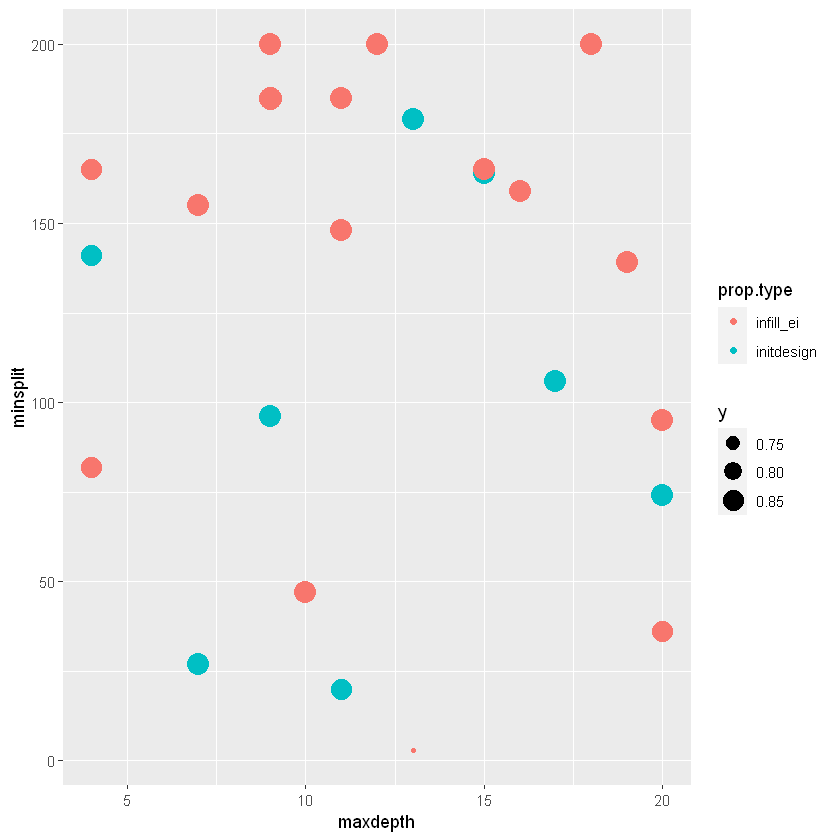

In [34]:
## Visualizamos
iter <- as.data.frame(run_md_ms$opt.path)
ggplot(iter, aes(y=minsplit,x=maxdepth, color=prop.type)) + geom_point(aes(size = y))